### This project reads a dataset including fake and clean data and determines if the data is fake or real. label column of the dataset has 0 and 1. 0 being fake and 1 being correct news. Following steps are taken:
1. load dataset
        
2. preprocessing:
    a. remive nulls   
    b. separated features & target
   
3. did value counts to find out how many fake and clean texts and visualized the data   
4. created word cloud to visualize the which word widely used in the texts
5. Further text processing:

   a. used stopwords library to eliminate words not needed in decision making
   
   b. eliminated punctuation from text
   
   c. performed lemmatization of texts (data scaling)
   
   d. transforming text data into a format suitable for machine learning (Vectorization)
   
   e. train test split data
   
   f. applied BernoulliNB, MultinomialNB Naive Bayes & Logistic Regression models
   
7. Visualize confusion matrix dat in heatmap
8. Visualize ROC curve to visualize model performance
9. Visualize performance of all three models with a histogram graph
10. Test models with user input
11. Save the high performance Linear Regression model for future use
  
  
   
   

In [741]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import RocCurveDisplay  # Import the class
import plotly.express as px
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [834]:
#!pip install nltk
#!pip install stopwords

In [835]:
df = pd.read_csv('WELFake_Dataset.csv')

In [836]:
df.shape

(72134, 4)

In [837]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [838]:
df.fillna(' ', inplace=True)

In [839]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [749]:
#df = df.head()

In [840]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [841]:
x = df.iloc[:, 2]
x.head()

0    No comment is expected from Barack Obama Membe...
1       Did they post their votes for Hillary already?
2     Now, most of the demonstrators gathered last ...
3    A dozen politically active pastors came here f...
4    The RS-28 Sarmat missile, dubbed Satan 2, will...
Name: text, dtype: object

In [842]:
y = df.iloc[:, 3].values # alternately y = df.iloc[:, 4]
y

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [843]:
# count the label column by spam and ham.
label_status = df['label'].value_counts()
label_status

label
1    37106
0    35028
Name: count, dtype: int64

In [844]:
transactions = label_status.index # index column of label_status
transactions

Index([1, 0], dtype='int64', name='label')

In [845]:
quantity = label_status.values  # value column of label_status
quantity

array([37106, 35028], dtype=int64)

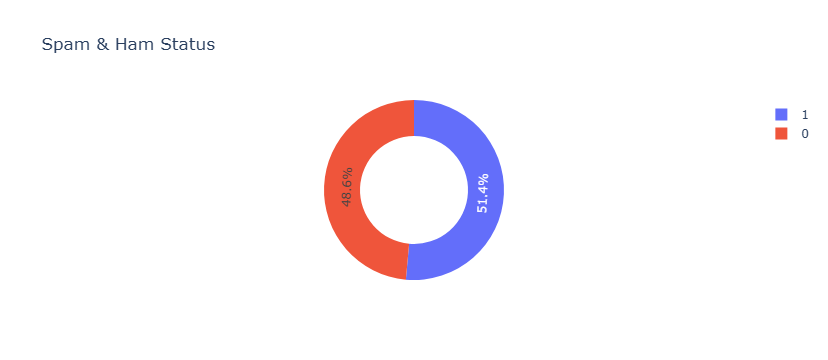

In [846]:
figure = px.pie(df, 
               values = quantity,
               names=transactions,
               hole = 0.6,
               title = 'Spam & Ham Status')
figure.show()

### Create word clouds

In [847]:
# function to plot fake and real text graph for visualization
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(title)

In [848]:
fake_text = ' '.join(df[df['label'] == 0]['text'])
real_text = ' '.join(df[df['label'] == 1]['text'])

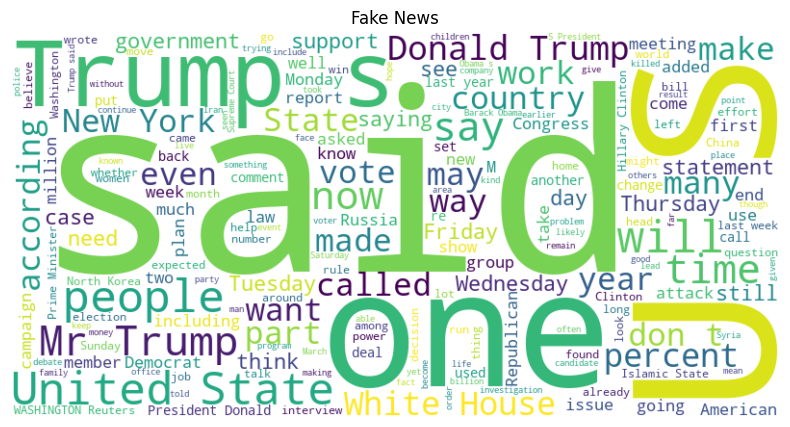

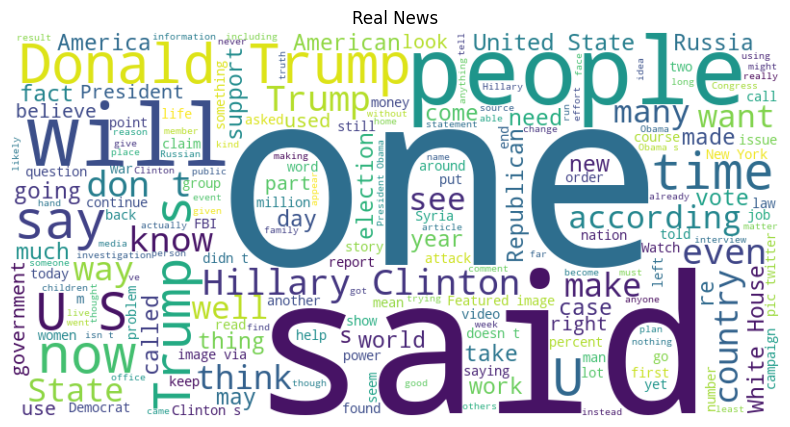

In [849]:
plot_wordcloud(fake_text, 'Fake News')
plot_wordcloud(real_text, 'Real News')

###  Text Preprocessing

In [850]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\islam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [851]:
stopword = set(stopwords.words('english') )
#stopword

In [852]:
# remove punctuation
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [853]:
def process_text(text):
    words_without_punc = [char for char in text if char not in string.punctuation]
    clean_words = ''.join(words_without_punc)
    text = [word for word in clean_words.split() if word.lower() not in stopword]
    return text # returns a list

In [854]:
df['text'] = df['text'].apply(process_text)

In [855]:
# so the text now does not have any punctuation or stopwords. and words are separated by commas and all words in lower case
df['text']

0        [comment, expected, Barack, Obama, Members, FY...
1                          [post, votes, Hillary, already]
2        [demonstrators, gathered, last, night, exercis...
3        [dozen, politically, active, pastors, came, pr...
4        [RS28, Sarmat, missile, dubbed, Satan, 2, repl...
                               ...                        
72129    [WASHINGTON, Reuters, Hackers, believed, worki...
72130    [know, fantasyland, Republicans, never, questi...
72131    [Migrants, Refuse, Leave, Train, Refugee, Camp...
72132    [MEXICO, CITY, Reuters, Donald, Trump’s, comba...
72133    [Goldman, Sachs, Endorses, Hillary, Clinton, P...
Name: text, Length: 72134, dtype: object

### Lemmatization (scaling the words in text column)

In [856]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\islam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [857]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    lemmatized_words = ' '.join([lemmatizer.lemmatize(word) for word in text])
    return lemmatized_words

In [858]:
df['text'] = df['text'].apply(lemmatize_text)

In [859]:
df['text'] 

0        comment expected Barack Obama Members FYF911 F...
1                                post vote Hillary already
2        demonstrator gathered last night exercising co...
3        dozen politically active pastor came private d...
4        RS28 Sarmat missile dubbed Satan 2 replace SS1...
                               ...                        
72129    WASHINGTON Reuters Hackers believed working Ru...
72130    know fantasyland Republicans never questioned ...
72131    Migrants Refuse Leave Train Refugee Camp Hunga...
72132    MEXICO CITY Reuters Donald Trump’s combative s...
72133    Goldman Sachs Endorses Hillary Clinton Preside...
Name: text, Length: 72134, dtype: object

### TF-IDF Vetorization

In [860]:
vectorizer = TfidfVectorizer()

In [861]:
x1 = vectorizer.fit_transform(df['text'])
x1

<72134x363127 sparse matrix of type '<class 'numpy.float64'>'
	with 14808182 stored elements in Compressed Sparse Row format>

In [862]:
y1 = y
y1

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

### Train Test Split

In [863]:
xtrain, xtest, ytrain, ytest = train_test_split(x1, y1, test_size=0.30, random_state=42)

### Evaluate Naive Bayes models

In [864]:
def evaluate_model(model, xtest, ytest):
    y_pred = model.predict(xtest)
    accuracy = accuracy_score(ytest, y_pred)
    cm = confusion_matrix(ytest, y_pred)
    return {
        'Accuracy': accuracy,
        'Confusion Matrix': cm
    }

### Multinomial Model

In [865]:
mnb_model = MultinomialNB()

In [866]:
mnb_model.fit(xtrain, ytrain)

MultinomialNB()

In [867]:
mnb_model.score(xtest, ytest)

0.8766692851531814

In [868]:
ym_pred = mnb_model.predict(xtest)
ym_pred

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [869]:
performance_mnb_model = evaluate_model(mnb_model, xtest, ytest)
performance_mnb_model

{'Accuracy': 0.8766692851531814,
 'Confusion Matrix': array([[9713,  900],
        [1769, 9259]], dtype=int64)}

### Bernoulli Model

In [870]:
bnb_model = BernoulliNB()

In [871]:
bnb_model.fit(xtrain, ytrain)

BernoulliNB()

In [872]:
yb_pred = bnb_model.predict(xtest)
yb_pred

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [873]:
performance_bnb_model = evaluate_model(bnb_model, xtest, ytest)
performance_bnb_model

{'Accuracy': 0.8547664156000185,
 'Confusion Matrix': array([[8575, 2038],
        [1105, 9923]], dtype=int64)}

In [874]:
cm = confusion_matrix(ytest, mnb_model.predict(xtest))
cm

array([[9713,  900],
       [1769, 9259]], dtype=int64)

### Function to generate heatmap for Bernoulli Naive Bayes, Multinomial Naive Bayes & Logistic Regression

In [875]:
# view the cm data in heat map. annot shows the data and fmt shows the data in integer format
def cm_heat_map(cm, xlabel, ylabel, title):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, 
                cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels = ['Actual 0', 'Actual 1'],
                annot=True,
                fmt='d')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    return sns.heatmap

<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

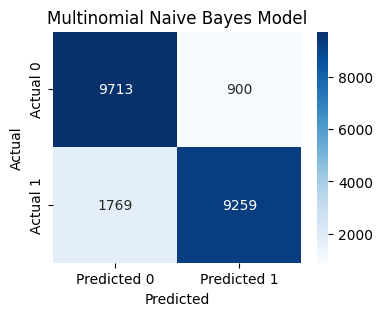

In [876]:
# call heatmap function
cm_heat_map(cm, 'Predicted', 'Actual', 'Multinomial Naive Bayes Model')

In [877]:
print(classification_report(ytest, mnb_model.predict(xtest)))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     10613
           1       0.91      0.84      0.87     11028

    accuracy                           0.88     21641
   macro avg       0.88      0.88      0.88     21641
weighted avg       0.88      0.88      0.88     21641



In [ ]:
#plot_roc_curve(mnb_model, xtest, ytest)
#plt.plot([0, 1], [0, 1])

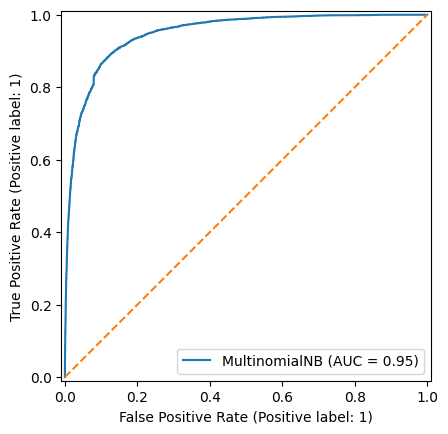

In [878]:
RocCurveDisplay.from_estimator(mnb_model, xtest, ytest)
plt.plot([0, 1], [0, 1], linestyle='--') # Plotting the diagonal line
plt.show()

### Try with Logistic Regression

In [879]:
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)

In [880]:
lr_model.fit(xtrain, ytrain)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [881]:
y_pred = lr_model.predict(xtest)
y_pred

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [882]:
performance_lr_model = evaluate_model(lr_model, xtest, ytest)   # Performance is good
performance_lr_model

{'Accuracy': 0.9515734023381545,
 'Confusion Matrix': array([[ 9999,   614],
        [  434, 10594]], dtype=int64)}

In [883]:
cm = confusion_matrix(ytest, lr_model.predict(xtest))
cm

array([[ 9999,   614],
       [  434, 10594]], dtype=int64)

<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

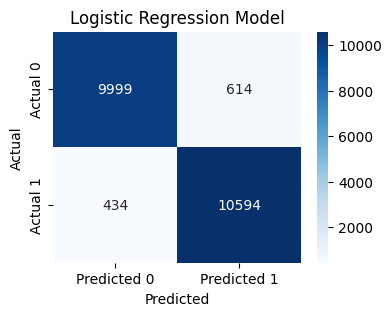

In [884]:
cm_heat_map(cm, 'Predicted', 'Actual', 'Logistic Regression Model')

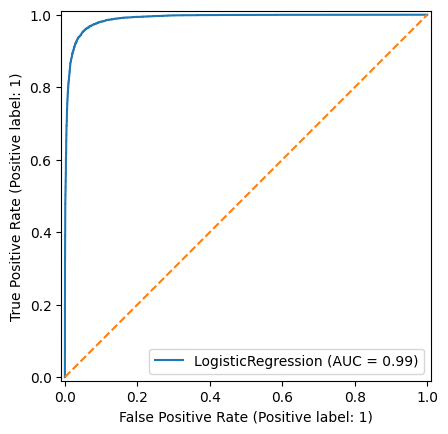

In [885]:
RocCurveDisplay.from_estimator(lr_model, xtest, ytest)
plt.plot([0, 1], [0, 1], linestyle='--') # Plotting the diagonal line
plt.show()

### Visualize Performance with histogram

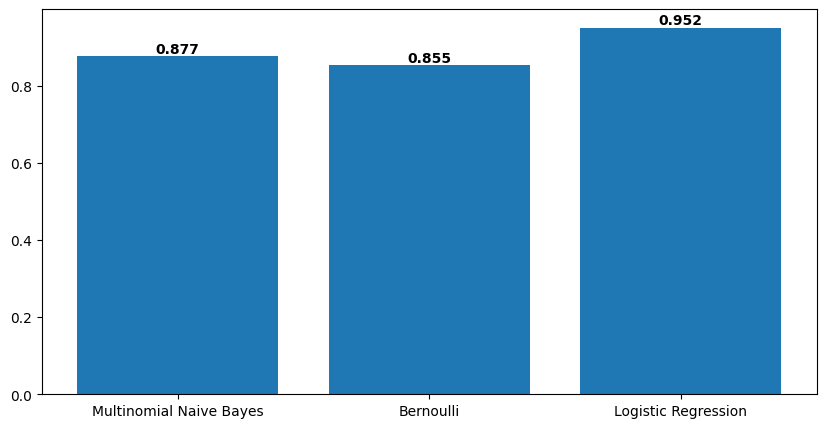

In [886]:
def plot_hist(metric_values, model_names, metric_names):
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(model_names, metric_values)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', color='black', fontweight='bold')
    plt.show()

accuracy_values = [
    performance_mnb_model['Accuracy'], 
    performance_bnb_model['Accuracy'], 
    performance_lr_model['Accuracy']
]
model_names = ['Multinomial Naive Bayes', 'Bernoulli', 'Logistic Regression']
plot_hist(accuracy_values, model_names, 'Accuracy' )

### Take user input and pass it through all steps and let the model predict
### As user input I entered few data from df['text'] columns and checked the prediction against the label values to make sure the model works properly

In [903]:
user_data = input()

 A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal traveled from Hinduism to Protestant Christianity and, ultimately, became what he calls an “evangelical Catholic.”\n\nOver two hours, Jindal, 42, recalled talking with a girl in high school who wanted to “save my soul,” reading the Bible in a closet so his parents would not see him and feeling a stir while watching a movie during his senior year that depicted Jesus on the cross.\n\n“I was struck, and struck hard,” Jindal told the pastors. “This was the Son of God, and He had died for our sins.”\n\nJindal’s session with the Christian clergy, who lead congregations in the early presidential battleground states of Iowa and South Carolina, was part of a behind-the-scenes effort by the Louisiana governor to find a political base that could help propel him into the top tier of Republican candidates seeking t

In [904]:
processed_text = process_text(user_data)
Lemmitized_text = lemmatize_text(processed_text)
vectorize_text = vectorizer.transform([Lemmitized_text])

In [ ]:
#vectorize_text

In [ ]:
#processed_text 

In [ ]:
#Lemmitized_text

In [ ]:
#vectorize_text.toarray()

In [802]:
#x[3]

In [905]:
models = {mnb_model, bnb_model, lr_model}

In [906]:
for model in models:
    prediction = model.predict(vectorize_text)
    print(f"Model : {type(model).__name__}")
    print("Prediction :",prediction[0])
    print('\n')

Model : MultinomialNB
Prediction : 0


Model : BernoulliNB
Prediction : 0


Model : LogisticRegression
Prediction : 0




### Save good performing model for future use

In [907]:
import pickle

model_file_path = 'logistic_regression_model.pkl' # define the file path where you want to save the model

# save
with open(model_file_path, 'wb') as model_file:
   pickle.dump(lr_model, model_file) 

